# DATASETS & DATALOADERS
- 데이터를 처리하는 코드는 복잡하고 유지하기 힘들 수 있음
- 그래서 데이터셋 관련 코드는 모델 학습과 분리되어야 가독성과 모듈성이 좋아짐
- 파이토치는 이를 위해 ```torch.utils.data.DataLoader``` 와 ```torch.utils.data.Dataset``` 을 제공함
- ```Dataset``` 은 샘플과 그 라벨을 저장해줌
- ```Dataloader``` 는 ```Dataset``` 을 wrap하여 iterable 하게 만들고 샘플에 접근하기 쉽게 해줌

- 파이토치는 이미 존재하는 유명한 데이터셋들을 많이 제공함 (FashionMNIST 등)
- 이런 데이터셋들은 우리 모델의 프로토타입이나 벤치마크에 사용할 수 있음
- **Image, Text, Audio** 등 다양함

---
# 1. Loading a Dataset
- 여기선 **TorchVision**으로부터 FashionMNIST 데이터셋을 로드하는 법에 대해 다룸
- **FashionMNIST** 데이터셋은 60,000개의 학습 데이터셋, 10,000개의 테스트셋으로 구성됨
- 각 샘플은 28x28 크기의 grayscale 이미지임
- 각 이미지는 10개의 클래스로 분류됨

> 여기선 FashionMNIST를 다음 파라미터를 통해 로드함
>- ```root``` : train/test 데이터가 저장된 path
>- ```train``` : train 데이터인지 / test 데이터인지
>- ```download = True``` : ```root``` 가 가능하지 않다면 인터넷으로부터 데이터를 직접 다운로드
>- ```transform``` and ```target_transform``` : feature 와 label 의 변환 방법을 정의

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [4]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

---
# 2. Iterating and Visualizing the Dataset
- ```Datasets``` 를 리스트처럼 임의로 인덱싱할 수 있음 : ```training_data[index]```
- ```matplotlib``` 라이브러리를 이용하여 몇몇 샘플을 시각화해보겠음

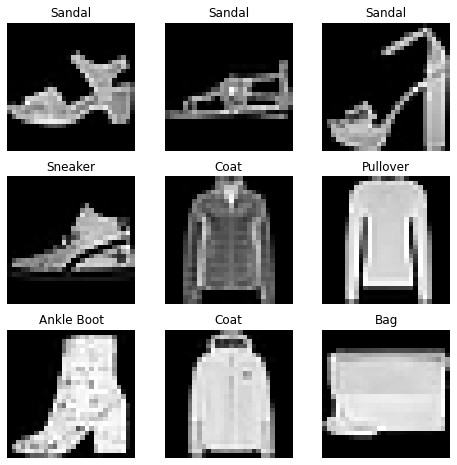

In [9]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag", 
    9: "Ankle Boot"
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(training_data), size=(1, )).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

---
# 3. Creating a Custom Dataset for yout files
>custom Dataset class 가 필수적으로 갖춰야 할 메서드 3가지
>1. **init** 
>2. **len**
>3. **getitem**

- 여기선 ```img_dir```에 저장된 FashionMNIST 이미지와 ```annotations_file```에 csv파일로 저장된 라벨을 이용해 직접 데이터셋을 만드는 법을 보겠음
- ```annotations_file```은 ```이미지 이름 , 이미지 라벨```로 구성되어야 함 (```tshirt1.jpg, 0```)

In [11]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

>**init**
>- Dataset 객체가 인스턴스로 생성될 때 처음 한 번만 실행
>- 이미지를 포함하고 있는 폴더, annotation file, 이미지와 라벨에 적용할 transform 등을 설정

>**len**
>- 데이터셋 샘플의 숫자를 반환

>**getitem**
>- 인덱스 ```idx```가 주어지면 데이터셋에서 해당 인덱스에 해당하는 샘플을 반환
>- 인덱스를 기반으로 해당 이미지의 위치를 파악한 뒤 ```read_image```함수로 이미지를 읽어옴
>- 해당 이미지에 해당하는 라벨도 이미 로드한 ```self.img_labels``` 에서 찾아옴
>- ```transform, target_transform```이 설정됐다면 적용 후 이미지와 라벨을 튜플로 반환

---
# 4. Preparing your data for training with DataLoaders
- ```Dataset```은 하나의 feature와 label을 반환함
- 하지만 모델을 학습할 때에는 주로 **미니배치** 샘플을 이용함
- 과적합을 방지하기 위해 매 에폭마다 데이터를 **shuffle**함
- 데이터 검색을 가속하기 위해 파이썬의 ```multiprocessing```을 이용함

- ```DataLoader```는 이 복잡한 작업을 도와줌

In [12]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

---
# 5. Iterate through the DataLoader
- 위에서 ```Dataset```을 ```DataLoader```로 로드함
- 이제 데이터셋을 필요에 따라 iterate할 수 있음
- 각 iteration에서 미니배치로 된 ```train_features```와 ```train_labels```를 반환함
- ```shuffle=True```로 설정하면 모든 배치가 iterate된 후에 데이터셋이 shuffle됨

In [14]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


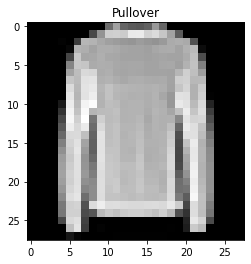

In [17]:
img = train_features[0].squeeze()
label = train_labels[0].item()
plt.imshow(img, cmap="gray")
plt.title(labels_map[label])
plt.show()